In [1]:
# ===============  Importing Files and Libraries ==================

import nibabel as nib           # To open nii files
import numpy as np              # Numerical computation library for python
import torch, torchvision       # Our deep learning framework
import matplotlib.pyplot as plt # To visualize plots and images

# If CUDA is not available, use 
device='cpu'
# device='cuda'

In [2]:
# First of all, a function to quickly return
# the data content from each MRI volume:

def niload(path):
    """
    Returns a numpy object from the nifti file path

    Parameters
    ----------
    path : str
        Path to the nifty file.

    Returns
    -------
    new : numpy.ndarray
        Nifti volume as a numpy object.

    """
    nob=nib.load(path, mmap=True, keep_file_open=False)
    data=nob.get_fdata()
    return data

# And now a function to crop the volume to the brain mask, with a small margin.
# This function will find the boundaries around the brain mask

def Box(Mask):
    S=Mask.shape
    LowX=0
    while np.sum(Mask[LowX,:,:])==0:
        LowX+=1
    
    LowY=0
    while np.sum(Mask[:,LowY,:])==0:
        LowY+=1
    
    LowZ=0
    while np.sum(Mask[:,:,LowZ])==0:
        LowZ+=1
    
    HighX=S[0]-1
    while np.sum(Mask[HighX,:,:])==0:
        HighX-=1
    
    HighY=S[1]-1
    while np.sum(Mask[:,HighY,:])==0:
        HighY-=1
        
    HighZ=S[2]-1
    while np.sum(Mask[:,:,HighZ])==0:
        HighZ-=1
        
    return LowX, HighX+1, LowY, HighY+1, LowZ, HighZ+1

# The following function will use them to crop a volume:

def Crop(vol,lims):
    LowX, HighX, LowY, HighY, LowZ, HighZ = lims
    
    return vol[:,LowX:HighX,LowY:HighY,LowZ:HighZ]

In [3]:
# ======== Select 'crop =  True' if you want to use the brain mask to crop the MRI images to save more on memory =============

# def AddVolume(dataset,labels,mask,template,crop=True):
def AddVolume(dataset,labels,mask,template,crop=False):
    """
    Append a data sample to the dataset list, given the path of MRI, labels,
    and brain mask.
    
    Parameters
    ----------
    dataset : list
        List the sample is appended to.
    labels : string
        Path to the labels volume, in atlas format (one value for each ROI).
    mask : string
        Path to the mask volume.
    template : string
        Path to MRI volume.

    Returns
    -------
    None.

    """
    # We load each volume in RAM
    L=niload(labels)
    M=niload(mask)
    MRI=niload(template)
    
    # LAB will be a container for the categorical labels (I am finetuning the model to 3 classes - Brain mask, Background and Hippocampi)
    # These volumes will be shaped [Channels, Depth, Height, Width].
    # Batch axis will be added later
    
    # Build a zeros volume with the same shape
    # as the original, and 2 channels here (background and hippocampi)
    
    LAB=np.zeros([2]+list(L.shape))
    # LAB=np.zeros([3]+list(L.shape)) 
    
    # Add the channel dimension to the brain mask
    # by using the reshape function.
    
    M=M.reshape([1]+list(M.shape))
    
    # Reshape the MRI volume to the same shape,
    # thus adding a channel axis. As a grayscale
    # image, the MRI scan only has a single channel:
    # only one imaging modality
    
    MRI=MRI.reshape(M.shape)
    
    
    # # For each indicated ROI:
    for k in range(int(L.max())+1):
        temp=np.zeros_like(L)
    
    # Set to 1 for each element labeled as k
    # k=0 represents the background class
        temp[L==k]=1
    
    # This is for the Background and Hippocampi
        if k!=2:
            LAB[k,:,:,:]=temp
        
    
    # We can now use the cropping functions to crop these volumes (if desired as stated before)
    if crop:
        
        boundaries = Box(M[0,:,:,:])
        
        M  =Crop(M,boundaries)
        MRI=Crop(MRI,boundaries)
        LAB=Crop(LAB,boundaries)
    
    # Each sample with be saved as a dictionary
    # with each entry indicating different types of data
    dataset.append({'template':MRI,
                    'mask':M,
                    'label':LAB,
                    'path':template})

In [5]:
# ==================== Building the Dataset ===============================

# We will need to crawn through our data folder.
# For that we will use the os library

import os
    
# Define a new class, starting from the Dataset class:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,datafolder='fine_tuning',transform=None,maxsamples=np.inf):
        """
        The __init__ function is run when the class is instantiated 
        
        Parameters
        ----------
        datafolder : string
            Path to the data folder, containing the template, mask and label
            folders.
        transform : transform function, optional
            A transform function or torchvision.transforms.Compose composition of transforms.
            The default is None.
        maxsamples : any number
            Max number of samples to acquire, useful if you have limited RAM memory
            and still want to run this code

        Returns
        -------
        None.

        """
        
        self.dataset=[]
        self.transform=transform
        
        # For each file in the template folder
        for file in os.scandir(os.path.join(datafolder,'template')):
            # If it's a nifti file
            if 'nii.gz' in file.name:
                # We take the respective files from the mask and label folder
                name=file.name
                mri=file.path
                labels=os.path.join(datafolder,'labels_hippo',name)
                mask=os.path.join(datafolder,'mask',name)
                
                AddVolume(self.dataset, labels, mask, mri)
                
                if len(self.dataset)>=maxsamples: break
        
    
    def __len__(self):
        """
        Lenght of the total dataset. Our default lenght method
        will be the same of the python list we use for the dataset

        Returns
        -------
        int
            Number of elements in dataset.

        """
        return len(self.dataset)
    
    def __getitem__(self,idx):
        """
        Extract one dataset item, identified by its index in the list.
        This method will be used when training our network

        Parameters
        ----------
        idx : int
            Position of desired element in dataset list.

        Returns
        -------
        sample : dict
            Dictionary of MRI, Labels and Mask for sample idx.

        """
        # By using the copy method from numpy, we will make sure
        # not to replace our original dataset items
        # when applying transforms
        sample=self.dataset[idx].copy()
        
        #We apply our transforms, the transform here will be defined later
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [6]:
labels=['Brain Mask',
         'Background',
         'Hippocampus R and Left']

In [7]:
# ========== To scale 3D volumes, we will use the zoom function from scipy ============

from scipy.ndimage.interpolation import zoom
import random

class Rescale():
    """
    Rescale the volumes to a given size.
    """

    def __init__(self, MaxScale,MinScale,probability):
        
        # As we define our transformation class,
        # we will decide on a probability of applying it
        # and on the minimum and maximum scale factor
        
        self.MinScale = MinScale
        self.span = MaxScale-MinScale
        self.probability=probability

    def __call__(self, sample):
        
        # First we decide whether to apply the transformation
        # with the specified probability
        
        if random.random()<self.probability:
            
            # We randomly pick a scale factor in the given range
            scaleFactor=self.MinScale + self.span * random.random()
            scaleFactor=(1,scaleFactor,scaleFactor,scaleFactor)
            
            # Let's apply the transformations.
            # For the MRI volume, we can interpolate with order 3
            sample['template']=zoom(sample['template'],scaleFactor,order=3)
            
            # We need to preserve the label information as integers:
            # we will use neares enighbor interpolation, order 0
            
            sample['mask']=zoom(sample['mask'],scaleFactor,order=0)
            
            # We will need to process each channel separately
            # for the label volume
            scaleFactor=scaleFactor[-3:]
            # build a new container volume
            shape=list(sample['mask'].shape)
            shape[0]=sample['label'].shape[0]
            newL=np.zeros(shape)
            
            # fill the volume
            for k in range(sample['label'].shape[0]):
                newL[k,:,:,:]=zoom(sample['label'][k,:,:,:],scaleFactor,order=0)
            sample['label']=newL
        
        return sample

C:\Users\mubar\AppData\Local\Temp\ipykernel_90052\2248645041.py:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [8]:
# ========== To normalize the Dataset ========================
class Normalizer():
    
    def __call__(self,sample):
        
        mean=np.mean(sample['template'])
        std=np.std(sample['template'])

        sample['template']=(sample['template'] - mean)/(np.sqrt(std))
        return sample

In [9]:
# =========== From Numpy to Tensor ===========
class ToTensor():
    
    def __init__(self,device=device):
        self.device=device
    
    def __call__(self,sample):
        for k in ['template','mask','label']:
            # Using the from_numpy method we can
            # quickly transform numpy arrays
            # to pytorch tensors
            sample[k] = torch.from_numpy(sample[k]).float().to(self.device)
        
        return sample

## The MU-NET Network

The Network is originally developed by "De Feo, R., Shatillo, A., Sierra, A., Valverde, J. M., Gröhn, O., Giove, F., & Tohka, J. (2021). Automated joint skull-stripping and segmentation with Multi-Task U-Net in large mouse brain MRI databases. NeuroImage, 229, 117734. https://doi.org/10.1016/j.neuroimage.2021.117734". Its structure is as shown below:


![Neural network architecture](img/net.png)

The next cell defines a dictionary outlining the parameters of the network, and in subsequent cells, each operation is defined.

In [10]:
from torch import nn

PARAMS={'Categories':2, # Number of categories, fine-tuned to 2 (Background and hippocampi)
        'FilterSize':3, # each single filter will be 3x3
        'FiltersNum':np.array([32, 32, 64, 64]), # From top to bottom, number of filters
        
        # number of filters for the last convolutional layer before splitting into different tasks    
        'ClassFilters':int(64),
        'Activation':nn.LeakyReLU,  # Activation function
        'InblockSkip':False, # Can be set to True if more GPU is available
        'PoolShape':(2,2,2), #Shape of the pooling operation
        # PyTorch classes used for each of type of layer:
        'BNorm':nn.BatchNorm3d,
        'Conv':nn.Conv3d,
        'Pool':nn.MaxPool3d,
        'Unpool':nn.MaxUnpool3d,
        }

# As a default tensor type, we will use float numbers
# Using double precision numbers would result in greater
# memory usage, for no significant benefit
if device == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

c:\Users\mubar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [11]:
# ======== Padding function in the case it is needed ===========
def FindPad(FilterSize):
    """
    Returns appropriate padding based on filter size.
    Input can be int, tumple, or numpy array
    
    By using an array, we can define convolution kernels
    of any size, for example (3,5,7). 
    However, this is not a common choice.
    """
    A=(np.array(FilterSize)-1)/2
    if type(FilterSize)==tuple:
        return tuple(A.astype(int))
    else:
        return int(A)

In [12]:
class OneConv(nn.Module):
    """
    Performs one single convolution: activation of previous layer, batchnorm,
    convolution
    FilterIn is the number of input channels, FilterNum output channels,
    PAR is the parameters dictionary, containing the classes we need
    
    We will control the filter size separately, as we will need to 
    change it for certain layers
    """


    def __init__(self,FilterIn,FilterNum, FilterSize,PAR):
        super(OneConv,self).__init__()
        
        # To avoid applying LeakyRELU on the input directly
        # we will define the activation as a identity function
        # if the input only includes one channel. Otherwise,
        # we will use the functions we chose previously.
        # We do the same for batch normalization.
        
        if FilterIn == 1:
            self.activate= lambda x: x
            self.norm= lambda x: x
        else:
            # Activation: 
            self.activate=PAR['Activation']()
            
            # When defining batch norm we need to expliciply
            # specify the number of input channels:
            self.norm=PAR['BNorm'](int(FilterIn))
        
        # For the convolution itself, we need to specify the
        # number of input and output channels, the size of
        # the filters, and the padding. We will find the padding
        # using the function we define earlier
        
        self.conv=PAR['Conv'](int(FilterIn),int(FilterNum),FilterSize,padding=FindPad(FilterSize) )
        
    def forward(self,layer):
        
        # With layer as the input:
        
        act=self.activate(layer)      # activation
        normalize=self.norm(act)      # normalization
        convolve=self.conv(normalize) # convolution
        
        return convolve

In [13]:
class Bottleneck(nn.Module):
    
    def __init__(self,FilterIn,FilterNum,FilterSize,PAR):
        super(Bottleneck,self).__init__()
        self.norm=PAR['BNorm'](int(FilterIn))
        self.conv=PAR['Conv'](int(FilterIn),int(FilterNum),FilterSize,padding=FindPad(FilterSize) )
        
    def forward(self,layer):
        normalize=self.norm(layer)
        convolve=self.conv(normalize)
        return convolve

In [14]:
class SkipConvBlock(nn.Module):
    """
    One full convolution block with skip connections
    FilterIn is the number of input channels, FilterNum output channels,
    filters are of size FilterSize
    """

    def __init__(self,FilterIn,FilterNum,FilterSize,PAR):
        super(SkipConvBlock,self).__init__()
        
        # We can now use the convolution module
        # we defined earlier to define all convolutions
        # inside the block
        
        self.conv1=OneConv(int(FilterIn),int(FilterNum),FilterSize=FilterSize,PAR=PAR)
        self.conv2=OneConv(int(FilterIn+FilterNum),int(FilterNum),FilterSize=FilterSize,PAR=PAR)
        self.conv3=OneConv(int(FilterIn+FilterNum*2),int(FilterNum),1,PAR=PAR)
        
    def forward(self,BlockInput):
        first=self.conv1(BlockInput)
        fconv=torch.cat((first,BlockInput),1)
        
        # in this case we use torch.cat to concatenate
        # the outputs of the different convolution blocks
        
        second=self.conv2(fconv)
        sconv=torch.cat((first,second,BlockInput),1)
        
        BlockOut=self.conv3(sconv)
        
        return BlockOut
    
class NoSkipConvBlock(nn.Module):
    """
    One full convolution block without skip connections
    FilterIn is the number of input channels, FilterNum output channels,
    filters are of size FilterSize
    """

    def __init__(self,FilterIn,FilterNum,FilterSize,PAR):
        super(NoSkipConvBlock,self).__init__()
        self.conv1=OneConv(int(FilterIn),int(FilterNum),FilterSize=FilterSize,PAR=PAR)
        self.conv2=OneConv(int(FilterNum),int(FilterNum),FilterSize=FilterSize,PAR=PAR)
        self.conv3=OneConv(int(FilterNum),int(FilterNum),1,PAR=PAR)
        
    def forward(self,BlockInput):
        
        # In this case we just need to feed one layer's 
        # output to the following layer
        
        first=self.conv1(BlockInput)
        second=self.conv2(first)
        BlockOut=self.conv3(second)
        
        return BlockOut

In [15]:
class MUnet(nn.Module):
    """
    Returns (Mask,Classes)
    Generated based on parameters
    """
    
    def __init__(self,PARAMS=PARAMS):
        super(MUnet,self).__init__()
        self.PARAMS=PARAMS
        
        # First of all we choose the conv block
        # based on the presence of skip connections
        if PARAMS['InblockSkip']:
            ConvBlock=SkipConvBlock
            self.skipper=True
        else:
            ConvBlock=NoSkipConvBlock
            self.skipper=False
        
        # We define a dictionary of modules to store
        # the layers we are about to initialize
        
        self.layers=nn.ModuleDict()
        
        # let's start with the encoder modules:
        # One dense block. We need to specify input and 
        # output channels
        
        self.layers['Dense_Down'+str(0)]=ConvBlock(1,
                                                   PARAMS['FiltersNum'][0],
                                                   FilterSize=PARAMS['FilterSize'],
                                                   PAR=PARAMS)
        
        # One pooling layer, returning the indexes of 
        # the pooled items, for layer unpooling
        # We just need to pass on the pooling shape
        
        self.layers['Pool'+str(0)]=PARAMS['Pool'](PARAMS['PoolShape'],return_indices=True) 
        
        # Repeat for each layer. The index i will
        # indicate the depth of the layer, where 
        # larger i means deeper
        
        for i in range(1,len(PARAMS['FiltersNum'])):
            self.layers['Dense_Down'+str(i)]=ConvBlock(PARAMS['FiltersNum'][i-1],
                                                       PARAMS['FiltersNum'][i],
                                                       FilterSize=PARAMS['FilterSize'],
                                                       PAR=PARAMS)
            self.layers['Pool'+str(i)]=PARAMS['Pool'](PARAMS['PoolShape'],return_indices=True) 
        
        # Bottleneck layer
        self.layers['Bneck']=Bottleneck(PARAMS['FiltersNum'][-1],
                                        PARAMS['FiltersNum'][-1],
                                        FilterSize=PARAMS['FilterSize'],
                                        PAR=PARAMS)
        
        # Layers on the decoding path:
        # Unpooling and convolution
        # Unpooling needs us to specify 
        # again the same pooling
        # shape we defined earlier
        
        self.layers['Up'+str(i)]=PARAMS['Unpool'](PARAMS['PoolShape'])
        
        self.layers['Dense_Up'+str(i)]=ConvBlock(PARAMS['FiltersNum'][-1]+PARAMS['FiltersNum'][-1],
                                                 PARAMS['FiltersNum'][-2],
                                                 FilterSize=PARAMS['FilterSize'],
                                                 PAR=PARAMS)
        
        for i in reversed(range(1,len(PARAMS['FiltersNum'])-1)):
            
            self.layers['Up'+str(i)]=PARAMS['Unpool'](PARAMS['PoolShape'])
            
            # The number of input channels here is twice the number of outputs,
            # as we will combine the unpooled maps and the maps from
            # the skip connections coming from the encoding path
            
            self.layers['Dense_Up'+str(i)]=ConvBlock(PARAMS['FiltersNum'][i]*2,
                                                     PARAMS['FiltersNum'][i-1],
                                                     FilterSize=PARAMS['FilterSize'],
                                                     PAR=PARAMS)
            
            
        self.layers['Up'+str(0)]=PARAMS['Unpool'](PARAMS['PoolShape'])
        
        # Generate the last parametric map, with ClassFilters number of channels
        
        self.layers['Dense_Up'+str(0)]=ConvBlock(PARAMS['FiltersNum'][0]*2,
                                                 PARAMS['ClassFilters'],
                                                 FilterSize=PARAMS['FilterSize'],
                                                 PAR=PARAMS)
        
        # Output layers: 
        # Classifier layer:
        # Size 1 convolution with as many channels 
        # as we have different categories
        
        self.layers['Classifier']=PARAMS['Conv'](PARAMS['ClassFilters'],
                                                 PARAMS['Categories'],
                                                 1)
        
        self.layers['BinaryMask']=PARAMS['Conv'](PARAMS['ClassFilters'],
                                                 1,
                                                 1)
        
        # The respective activation functions:
        
        self.softmax=nn.Softmax(dim=1)
        self.sigmoid=nn.Sigmoid()
            
            
    def forward(self,MRI):
        
        # We will store the parametric maps in these dictionaries:
        
        pools={}
        dense={}
        Updense={}
        Unpool={}
        
        # Encoding path:
        # we can overwrite the pooled maps with the output
        # of the following dense block, we will need
        # to keep the rest
        # The pools dictionary contains the 
        # saved indexes from pooling operations
        
        dense[0] = self.layers['Dense_Down'+str(0)](MRI)
        dense[1], pools[0] = self.layers['Pool'+str(0)](dense[0])
        
        for i in range(1,len(self.PARAMS['FiltersNum'])):
            dense[i] = self.layers['Dense_Down'+str(i)](dense[i])
            dense[i+1], pools[i] = self.layers['Pool'+str(i)](dense[i])
        
        # Bottleneck layer
        
        BotNeck = self.layers['Bneck'](dense[i+1])
        
        
        # Deconding path:
        # Unpool:
        
        Unpool[i] = self.layers['Up'+str(i)](BotNeck,pools[i],output_size=dense[i].size())
        
        # Concatenate with the encoded maps.
        
        # Simple operations like this, requiring no
        # parameters and defining no new functions,
        # do not need to be initialized with the class
        # as new layers, and can be applied directly
        # in the forward function.
        
        cat=torch.cat([Unpool[i],dense[i]],dim=1)
        
        # Convolution block:
        Updense[i] = self.layers['Dense_Up'+str(i)](cat)
        
        # Repeat for each layer
        for i in reversed(range(len(self.PARAMS['FiltersNum'])-1)):
            
            Unpool[i]=self.layers['Up'+str(i)](Updense[i+1],pools[i],output_size=dense[i].size())
            cat=torch.cat([Unpool[i],dense[i]],dim=1)
            Updense[i]=self.layers['Dense_Up'+str(i)](cat)
        
        # Output layers
        MultiClass=self.layers['Classifier'](Updense[0])
        MonoClass=self.layers['BinaryMask'](Updense[0])
        
        # Return the activated layers:
        
        return self.sigmoid(MonoClass), self.softmax(MultiClass)

## Loss

We typically evaluate the accuracy of our network using the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient): twice the size of the intersection between the two volumes divided by the sum of the sized of both volumes. 

![Dice coefficient](img/dice.png)

It makes sense then to build a loss function out of the same metric. For M categories, following [Sudre et al.](https://link.springer.com/chapter/10.1007/978-3-319-67558-9_28):

![Dice loss](img/loss.png)

Optimizing directly for the Dice loss has proven to achieve better results than cross entropy. Let's define this loss function using PyTorch operations. 

In [16]:
def DiceLoss(Ytrue,Ypred):
    """
    Returns the Dice loss between predicted and reference torch tensors.
    Order is optional.

    Parameters
    ----------
    Ytrue : torch.tensor
        Reference tensor.
    Ypred : torch.tensor
        Predicted tensor.

    Returns
    -------
    DICE : torch.tensor
        Dice loss, scalar value.

    """

    DICE = -torch.div(
        torch.sum(torch.mul(torch.mul(Ytrue,Ypred),2)),
        torch.sum(torch.mul(Ypred,Ypred)) + torch.sum(torch.mul(Ytrue,Ytrue))
        )
    
    return DICE

# Our network output will be in the form of (Mask,ROIs)
# so let's write a function to evaluate both tasks:

def Loss(Ytrue,Ypred):
    
    return DiceLoss(Ytrue[0],Ypred[0]) + DiceLoss(Ytrue[1],Ypred[1])  # O for mask and 1 for the Labels

In [17]:
# =================== Training after Finetuning the Network (Begin) ==================================

Max_Samples=6 # Depends on available data for finetuning

import time, tqdm

# Since dataset is small, validating after every 5 epochs is better
testinterval=5 # epochs
maxtime=3*60*60 # in senconds  (Retrained for three hours)


Bsize=1 # batch size

# instantiate the network:
UN=MUnet(PARAMS).to(device)
# UN=MUnet(PARAMS).to('cuda')

# Adam Optimizer
# optimizer=torch.optim.Adam(UN.parameters(), weight_decay=0.01)
optimizer=torch.optim.Adam(UN.parameters())

# Calling the Rescale, Normalizing and Tensor functions 
scaler = Rescale(0.95,0.85,1)
# scaler = Rescale(0.95,0.5,1)
normalizator = Normalizer()
tensorize = ToTensor()

# Combining the 3 into a transform. Rescaling can be used or avoided. 

# transforms = torchvision.transforms.Compose([ normalizator, scaler,  tensorize])
transforms = torchvision.transforms.Compose([ normalizator,  tensorize])

# Let's redefine the dataset now, using these transforms.
dataset=Dataset(transform=transforms,maxsamples=Max_Samples)

# Custom loop for choosing the training and validation samples. This can also be randomized. 
test_idxs = []
train_idxs = []
for i in range(Max_Samples):
    if i == 2 or i ==5:
        test_idxs.append(i)
    else:
        train_idxs.append(i)

print('Training samples: ',train_idxs)
print('Validation samples: ',test_idxs)

Training samples:  [0, 1, 3, 4]
Validation samples:  [2, 5]


torch.Size([1, 228, 264, 160])
torch.Size([1, 228, 264, 160])
torch.Size([1, 228, 264, 160])
torch.Size([1, 228, 264, 160])


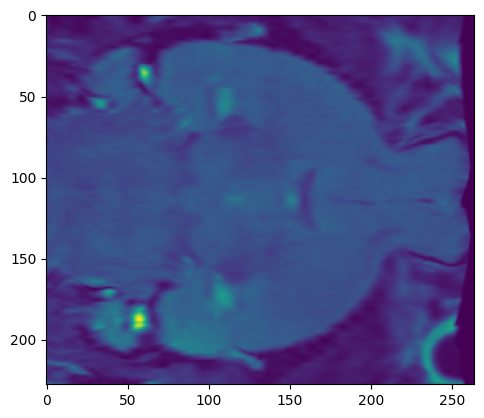

In [19]:
# print(dataset[1]['label'][0].max())
# plt.imshow(dataset[1]['mask'][0][:,:,50])
plt.imshow(dataset[0]['template'][0][:,:,50])
# plt.imshow(dataset[1]['label'][1][:,:,50])

# Checking the dataset after building to tensors 
print(dataset[1]['template'].shape)
print(dataset[3]['template'].shape)
print(dataset[4]['template'].shape)
print(dataset[2]['template'].shape)

In [20]:
# Trainloader and Validationloader to construct into batches

trainloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=Bsize,
                                          sampler=torch.utils.data.SubsetRandomSampler(train_idxs))
testloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=Bsize,
                                         sampler=torch.utils.data.SubsetRandomSampler(test_idxs))

In [21]:
# len(trainloader)
a = next(iter(trainloader))
a['template'].device

device(type='cpu')

In [22]:
# ========= The DiceScore function for evaluating the performance ==========
def FullDice(Ytrue,Ypred):
    
    # To move a tensor back to numpy, we need to:
    # 1. Detach it from the automatic differentiator
    # 2. Move it to RAM memory
    # 3. Convert to numpy array:
    Mask=Ypred[0].detach().cpu().numpy()
    
    # Threshold the mask output to a binary mask
    Mask[Mask>=0.5]=1
    Mask[Mask!=1]=0
    
    # Take the maximum channel-wise for the ROIs,
    # set the rest to zero
    
    labels=Ypred[1].detach().cpu().numpy()
    labels [np.where(labels== np.amax(labels,axis=1))] = 1
    labels[labels!=1]=0
    
    # Get the Dice scores for brain mask, background and all ROIs:
    Ypred=np.concatenate((Mask,labels),axis=1)
    Ytrue=np.concatenate((Ytrue[0].cpu().numpy(), Ytrue[1].cpu().numpy()),axis=1)


    dice=2*np.sum(Ytrue*Ypred,(0,2,3,4))/(np.sum((Ytrue+Ypred),(0,2,3,4)))
    
    return dice

In [23]:
# ======== Loading the parameters of the saved model as initialization ======== 
checkpoint=torch.load('savefile.tar',map_location=torch.device('cpu'))


optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
UN.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [24]:
# We will keep track of the elapsed time using the time library

# ==================================== The training Cell =========================================

time_check=time.time()
# Set training mode
UN.train()

TotalTime=0
epoch=0


#initialzie the best loss to an high value
bestloss=np.inf
    
while TotalTime < maxtime:
    
    # We will check the running mean of the loss function
    # on the training set
    
    runloss=[]

    UN.train()
    
    # Iterate over the training set, using the dataloader
    
    for i, sample in tqdm.tqdm(enumerate(trainloader),total=len(trainloader)):
        
        # Clear cache, just in case
        torch.cuda.empty_cache()
        

        # Zero the gradient
        optimizer.zero_grad()
        
        # Forward propagation:
        out = UN(sample['template'].float())
        
        # Extract the ground truth for this sample
        true=(sample['mask'],sample['label'])
        
        # Calculate the loss
        loss = Loss(true,out)

        # Backpropagation: get the gradient  
        loss.backward()
        
        # Gradient descent
        optimizer.step()
        
        # Append the loss for each batch
        runloss.append(loss.detach().cpu().numpy())
        
            
    # Let's have a look at the running mean 
    # And the Dice scores for the last volume in the training set
    print('Last training sample Dices:')
    print(FullDice(true,out))
    print('Training set running mean loss: ')
    print(np.nanmean(runloss), flush=True)


    epoch+=1
    # Set evaluation mode. We will not save the gradient
    # and will need no backpropagation here.
    UN.eval()
    dices=[]
    losses=[]
    
    # Add time to the elapsed time. 
    TotalTime+=time.time()-time_check
    time_check=time.time()
    
    # Only evaluate after 5 Epochs with the Validation Set
    if epoch % testinterval==0:
        for i, sample in enumerate(testloader):
            with torch.no_grad(): # no need for gradient when evaluating
                # just in case
                torch.cuda.empty_cache()

                out = UN(sample['template'].float())
                true=(sample['mask'],sample['label'])
                loss = Loss(true,out)
     
                dices.append(FullDice(true,out))
                losses.append( float(loss))
        
        inftime=(time.time()-time_check)/len(testloader)
        print('Inference time: '+str(inftime)+' per volume')
        
        # Get the dice scores
        dices=np.array(dices)
        
        
        candidate_loss=np.mean(losses)
        longdices=np.mean(dices,axis=0)
        dices=np.nanmean(dices)
        dicesstd=np.nanstd(dices)
        
        # If we have a lower loss, save the model
        
        if candidate_loss<bestloss: 
            bestloss=candidate_loss
            
            torch.save({
                   'epoch': epoch,
                   'model_state_dict': UN.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': loss,
                   'bestloss':bestloss,
                   'dice_scores':dices,
                   'TotalTime':TotalTime,
                   'split':(train_idxs, test_idxs)
                   }, 'savefile.tar')
        
        print('\nTest set dices:')
        print('{:.5f}'.format(dices)+' ± {:.5f}'.format(dicesstd))
        print(longdices)

100%|██████████| 4/4 [14:10<00:00, 212.62s/it]


Last training sample Dices:
[0.98736453 0.99842703 0.92366165]
Training set running mean loss: 
-1.9860047


100%|██████████| 4/4 [12:17<00:00, 184.27s/it]


Last training sample Dices:
[0.9874291 0.9978067 0.8782374]
Training set running mean loss: 
-1.9859276


100%|██████████| 4/4 [13:29<00:00, 202.31s/it]


Last training sample Dices:
[0.9876031  0.99829274 0.915092  ]
Training set running mean loss: 
-1.9857043


100%|██████████| 4/4 [13:51<00:00, 207.98s/it]


Last training sample Dices:
[0.98769575 0.9986125  0.928264  ]
Training set running mean loss: 
-1.9865099


100%|██████████| 4/4 [12:19<00:00, 185.00s/it]


Last training sample Dices:
[0.9882844  0.99857306 0.9255455 ]
Training set running mean loss: 
-1.987044
Inference time: 18.641276001930237 per volume

Test set dices:
0.94587 ± 0.00000
[0.97873235 0.99775434 0.8611257 ]


100%|██████████| 4/4 [12:27<00:00, 186.96s/it]


Last training sample Dices:
[0.98864007 0.99879956 0.940281  ]
Training set running mean loss: 
-1.9879456


100%|██████████| 4/4 [12:50<00:00, 192.64s/it]


Last training sample Dices:
[0.98598456 0.99849343 0.8674633 ]
Training set running mean loss: 
-1.9882123


100%|██████████| 4/4 [13:32<00:00, 203.05s/it]


Last training sample Dices:
[0.9861555  0.99849534 0.8686066 ]
Training set running mean loss: 
-1.9885225


100%|██████████| 4/4 [12:53<00:00, 193.37s/it]


Last training sample Dices:
[0.9869989  0.9985735  0.86913604]
Training set running mean loss: 
-1.9890189


100%|██████████| 4/4 [13:18<00:00, 199.55s/it]


Last training sample Dices:
[0.9887276 0.9989315 0.9455969]
Training set running mean loss: 
-1.9889209
Inference time: 19.548519015312195 per volume

Test set dices:
0.94109 ± 0.00000
[0.97770095 0.9976249  0.84795046]


100%|██████████| 4/4 [13:32<00:00, 203.19s/it]


Last training sample Dices:
[0.98970664 0.99907494 0.95361716]
Training set running mean loss: 
-1.9891919


100%|██████████| 4/4 [12:41<00:00, 190.44s/it]


Last training sample Dices:
[0.98919487 0.99881715 0.93964523]
Training set running mean loss: 
-1.9892471


100%|██████████| 4/4 [11:31<00:00, 172.78s/it]


Last training sample Dices:
[0.98950446 0.99899787 0.95070136]
Training set running mean loss: 
-1.9897243


100%|██████████| 4/4 [12:29<00:00, 187.40s/it]


Last training sample Dices:
[0.9900949 0.9991745 0.9582722]
Training set running mean loss: 
-1.9897351


In [25]:
# =========== To print the Summary and save the model after training ======
# torch.cuda.memory_summary()


torch.save({ 'epoch': epoch,
            'model_state_dict': UN.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'loss': loss,
            # 'bestloss':bestloss,
            'dice_scores':dices,
            'TotalTime':TotalTime,
            'split':(train_idxs, test_idxs)
            }, 'savefile.tar')

## The Cell below is used to evaluate the finetuned model on the test data after training for some hours 

In [26]:
# First, let's take a sample from the test dataset

test_data=next(iter(testloader))
test_data['template'].device

test_data['template'].max()

tensor(15.0183)

Dice scores:

 [0.98745424 0.9987593  0.93833184]

Average Dice score:  0.97484845
torch.Size([1, 1, 228, 264, 160])
tensor(1.)
tensor(1.)
tensor(1.)


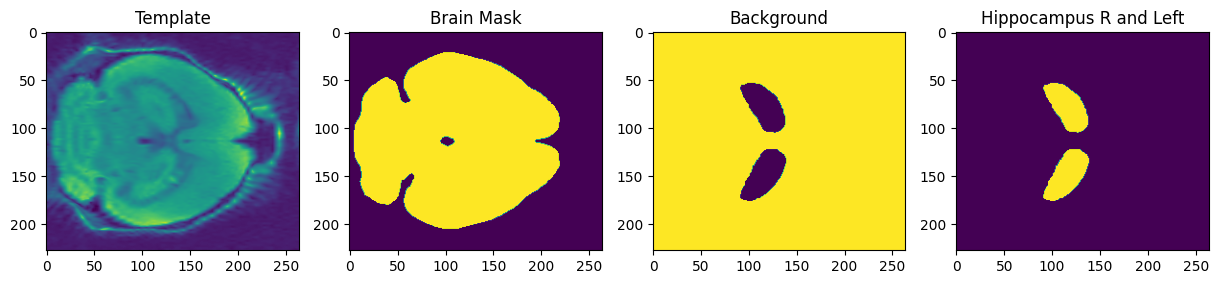

In [31]:
# Run this cell to evaluate the trained model

UN.eval()
with torch.no_grad(): # no need for gradient when evaluating
    torch.cuda.empty_cache()
    out=UN(test_data['template'])
    
    true=(test_data['mask'],test_data['label'])

    loss = Loss(true,out)
    dices=FullDice(true,out)

print('Dice scores:\n\n',dices)
print('\nAverage Dice score: ',np.mean(dices))

plt.figure(figsize=(15,10))

plt.subplot(3, 4, 1)
plt.imshow(test_data['template'].detach().cpu().numpy()[0,0,:,:,120])
plt.title('Template')

print(out[0].shape)
print(out[0].max())
print(out[1][0,0,:,:,:].max())
print(out[1][0,1,:,:,:].max())
# print(out[1][0,2,:,:,:].max())

plt.subplot(3, 4, 2)
plt.imshow(out[0].detach().cpu().numpy()[0,0,:,:,120])
plt.title(labels[0])

plt.subplot(3, 4, 3)   #Background
plt.imshow(out[1].detach().cpu().numpy()[0,0,:,:,120])
plt.title(labels[1])

plt.subplot(3, 4, 4)   #Hippo R and L
plt.imshow(out[1].detach().cpu().numpy()[0,1,:,:,120])
plt.title(labels[2])


plt.show()

## Observation on the test set

- The images above show the segmentation for the 120th slice. As can be observed in the Dice score for the Hippocampi, 93.8% after training on finetuning the model for 3 hours. With additional hours of training, the dice score can be improved. The images are very complex in size, so the model needs more hours of training to learn the difficult pattern in the data. 

- The segmentation for each slice is obtained and the composition of the slices is the resulting 3D volume. 